In [1]:
import pandas as pd
from nltk import tokenize, pos_tag
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pickle

In [2]:
btc = pd.read_csv('../data/btcusd.csv')

# Reddit comments

# Create Reddit comments basetable

In [3]:
COINLIST = {
#     'ETH': 'Ethereum',
    'BTC': 'Bitcoin',
#     'XMR': 'Monero',
#     'LTC': 'Litecoin',
#     'DASH': 'Dash'
}

In [4]:
def extract_subject(words):
    subjects = set()
    for word in words:
        if word in COINLIST.keys() or word.upper() in COINLIST.keys():
            subjects.add(COINLIST[word.upper()])
        elif word in COINLIST.values() or word.capitalize() in COINLIST.values():
            subjects.add(word.capitalize())
    return list(subjects)

In [5]:
sid = SentimentIntensityAnalyzer()

In [63]:
reddit = pd.read_csv('../data/CryptoCurrency_comments_20190101.csv', low_memory=False)

In [64]:
reddit = reddit.loc[~reddit.body.isin(['[deleted]', '[removed]'])]

In [65]:
reddit = reddit.loc[reddit.body.notna()]

In [67]:
reddit['created_utc'] = pd.to_datetime(reddit['created_utc'], unit='s')

In [66]:
# reddit['sentence'] = reddit['body'].apply(tokenize.sent_tokenize)

In [68]:
# reddit = reddit.explode('sentence')

In [69]:
# reddit = reddit.loc[reddit.sentence.notna()]

In [70]:
reddit['words'] = reddit['body'].apply(tokenize.word_tokenize) 

In [71]:
reddit['subjects'] = reddit['words'].apply(extract_subject)

In [72]:
reddit = reddit.loc[reddit['subjects'].apply(len) > 0]

In [73]:
reddit['sentiment'] = reddit['body'].apply(lambda x: sid.polarity_scores(x)['compound'])

In [74]:
reddit = reddit.explode('subjects')

In [75]:
basetable = reddit[['subjects', 'created_utc', 'sentiment']].sort_values('created_utc')

In [76]:
basetable['row_number'] = basetable.groupby('created_utc').cumcount() + 1

In [77]:
basetable = basetable.set_index('created_utc')

In [78]:
pickle.dump(basetable, open('../data/basetable_comments_20190101.p', 'wb'))

# Feature engineering

In [79]:
basetable = pickle.load(open('../data/basetable_comments_20190101.p', 'rb'))

In [112]:
time_windows = ['1h', '2h', '3h', '4h', '1d', '1d', '2d', '3d', '4d', '5d', '6d', '7d']

In [113]:
basetable_sentiment = None
for time_window in time_windows:
    ma_window = basetable.groupby('subjects')['sentiment'].rolling(time_window).mean()
    ma_window.name = 'sentiment_' + time_window
    if basetable_sentiment is None:
        basetable_sentiment = ma_window
    else:
        basetable_sentiment = pd.concat([basetable_sentiment, ma_window], 1)
basetable_sentiment = basetable_sentiment.reset_index()

In [114]:
basetable_sentiment.head(50)

,subjects,created_utc,sentiment_1h,sentiment_2h,sentiment_3h,sentiment_4h,sentiment_1d,sentiment_1d,sentiment_2d,sentiment_3d,sentiment_4d,sentiment_5d,sentiment_6d,sentiment_7d
0,Bitcoin,2019-01-01 00:02:36,0.194800,0.194800,0.194800,0.194800,0.194800,0.194800,0.194800,0.194800,0.194800,0.194800,0.194800,0.194800
1,Bitcoin,2019-01-01 00:05:19,0.555700,0.555700,0.555700,0.555700,0.555700,0.555700,0.555700,0.555700,0.555700,0.555700,0.555700,0.555700
2,Bitcoin,2019-01-01 00:05:25,0.194900,0.194900,0.194900,0.194900,0.194900,0.194900,0.194900,0.194900,0.194900,0.194900,0.194900,0.194900
3,Bitcoin,2019-01-01 00:09:28,0.285775,0.285775,0.285775,0.285775,0.285775,0.285775,0.285775,0.285775,0.285775,0.285775,0.285775,0.285775
4,Bitcoin,2019-01-01 00:12:26,0.426460,0.426460,0.426460,0.426460,0.426460,0.426460,0.426460,0.426460,0.426460,0.426460,0.426460,0.426460
5,Bitcoin,2019-01-01 00:14:48,0.418283,0.418283,0.418283,0.418283,0.418283,0.418283,0.418283,0.418283,0.418283,0.418283,0.418283,0.418283
6,Bitcoin,2019-01-01 00:22:21,0.401229,0.401229,0.401229,0.401229,0.401229,0.401229,0.401229,0.401229,0.401229,0.401229,0.401229,0.401229
7,Bitcoin,2019-01-01 00:35:19,0.438025,0.438025,0.438025,0.438025,0.438025,0.438025,0.438025,0.438025,0.438025,0.438025,0.438025,0.438025
8,Bitcoin,2019-01-01 00:47:03,0.469178,0.469178,0.469178,0.469178,0.469178,0.469178,0.469178,0.469178,0.469178,0.469178,0.469178,0.469178
9,Bitcoin,2019-01-01 00:52:56,0.422260,0.422260,0.422260,0.422260,0.422260,0.422260,0.422260,0.422260,0.422260,0.422260,0.422260,0.422260


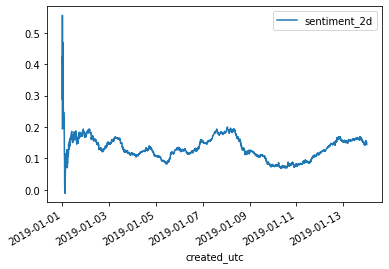

In [127]:
basetable_sentiment.loc[basetable_sentiment.created_utc < '2019-01-14'].plot('created_utc', 'sentiment_2d')